# SVM

Support Vector Machines - The algorithm works by finding the optimal decision boundary, known as the hyperplane, that separates the data points of different classes while maximizing the margin between the hyperplane and the closest data points of each class.

The hyperplane is chosen so that it has the largest possible distance from the closest data points of each class, which helps to improve the generalization performance of the model.

SVMs can handle both linearly separable and non-linearly separable datasets.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import os
import random
import cv2
%matplotlib inline

In [29]:
downscaling = 4

In [30]:
def generate_data(data_path, grayscale=False, downscale=None):
    cardboard, glass, metal, paper, plastic, trash = [], [], [], [], [], []
    for root, _, files in os.walk(data_path):
        for file in files:
            if ".jpg" in file:

                if grayscale:
                    img = cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2GRAY)
                else:
                    img = cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2RGB)
                
                if downscale:
                    new_size = (int(img.shape[1]/downscale), int(img.shape[0]/downscale))
                    img = cv2.resize(img, new_size)

                if "cardboard" in file: cardboard.append(img)
                elif "glass" in file: glass.append(img)
                elif "metal" in file: metal.append(img)
                elif "paper" in file: paper.append(img)
                elif "plastic" in file: plastic.append(img)
                elif "trash" in file: trash.append(img)
                else: print(f"Unable to classify image: {file}")
    images = {"cardboard": np.array(cardboard), "glass": np.array(glass), "metal": np.array(metal),
              "paper": np.array(paper), "plastic": np.array(plastic), "trash": np.array(trash)}
    return images

labels = {"cardboard": 0, "glass": 1, "metal": 2, "paper": 3, "plastic": 4, "trash": 5}

def train_test_split(images, train_size=0.8):
    data = []
    for key, value in images.items():
        for img in value: 
            data.append([img, labels[key]])
    
    random.shuffle(data)
    train_size = int(len(data) * train_size)

    X_train = np.array([np.ravel(e[0]) for e in data[:train_size]])
    y_train = np.array([e[1] for e in data[:train_size]])

    X_test = np.array([np.ravel(e[0]) for e in data[train_size:]])
    y_test = np.array([e[1] for e in data[train_size:]])

    return X_train/255, y_train, X_test/255, y_test

In [31]:
original_images = generate_data("data", downscale=downscaling)
X_train, y_train, X_test, y_test = train_test_split(original_images, train_size=0.9)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_Test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (2274, 36864)
y_train: (2274,)
X_Test: (253, 36864)
y_test: (253,)


### SVC

Support Vector Classification - A specific implementation of SVMs for binary classification tasks. Can be extended to handle multiclass classification problems by using one-vs-one or one-vs-all strategies.

Here, the default option of the Scikit-Learn's SVC model is OVR.

In [32]:
svc = svm.SVC(gamma=0.002, C=100)
svc.fit(X_train, y_train)

SVC(C=100, gamma=0.002)

In [33]:
from sklearn import metrics
import seaborn as sns

In [34]:
def show_confusion_matrix(confusion_matrix, score):
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix, annot=True, linewidths=0.5, square=True, cmap="Blues_r")
    plt.xlabel("Actual Labels")
    plt.ylabel("Predicted Labels")
    plt.title(f"Accuracy Score: {score}")

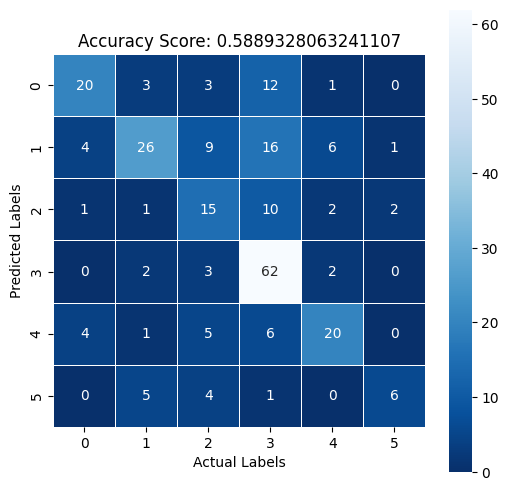

In [35]:
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

show_confusion_matrix(confusion_matrix, score)

We have reached about the same score as the KNN model before, but without PCA.

Let's try using PCA here as well, to furthur improve the performance.

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

After tinkering with the number of components, I found a good range.

In [42]:
sc = StandardScaler()

accuracies = {}
min_n_components = 25
max_n_components = 75

for n in range(min_n_components, max_n_components+1, 5):
    X_train_pca = sc.fit_transform(X_train)
    X_test_pca = sc.transform(X_test)

    pca = PCA(n_components=n)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    svc_pca = svm.SVC(gamma=0.002, C=100)
    svc_pca.fit(X_train_pca, y_train)

    score_pca = svc_pca.score(X_test_pca, y_test)

    print(f"n components: {n}/{max_n_components}, accuracy: {score_pca}")

    accuracies[n] = score_pca

n components: 25/75, accuracy: 0.6482213438735178
n components: 30/75, accuracy: 0.6679841897233202
n components: 35/75, accuracy: 0.6600790513833992
n components: 40/75, accuracy: 0.6679841897233202
n components: 45/75, accuracy: 0.6561264822134387
n components: 50/75, accuracy: 0.6600790513833992
n components: 55/75, accuracy: 0.6640316205533597
n components: 60/75, accuracy: 0.6640316205533597
n components: 65/75, accuracy: 0.6561264822134387
n components: 70/75, accuracy: 0.6521739130434783
n components: 75/75, accuracy: 0.6600790513833992


Again, picking the best number of components

In [43]:
best_n_components = max(accuracies, key=accuracies.get)

X_train_pca = sc.fit_transform(X_train)
X_test_pca = sc.transform(X_test)

pca = PCA(n_components=best_n_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Best n componenets: {best_n_components}")

svc_pca = svm.SVC(gamma=0.002, C=100)
svc_pca.fit(X_train_pca, y_train)

Best n componenets: 30


SVC(C=100, gamma=0.002)

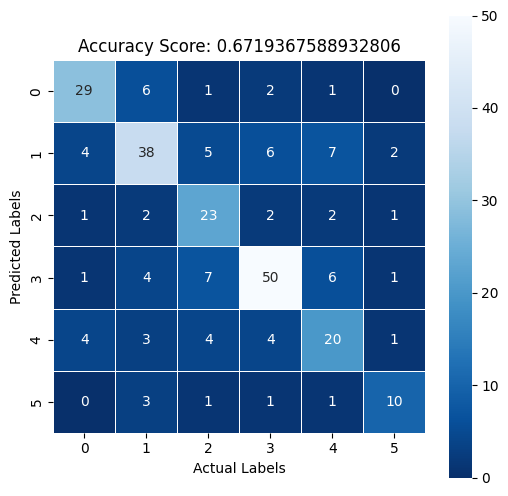

In [44]:
y_pred_pca = svc_pca.predict(X_test_pca)
score_pca = svc_pca.score(X_test_pca, y_test)
confusion_matrix_pca = metrics.confusion_matrix(y_test, y_pred_pca)

show_confusion_matrix(confusion_matrix_pca, score_pca)

An accuracy of 67%!